 ### Prueba de modelos sin estandarizar y sin normalizar

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import gensim # take text for clean and tokenize list of words
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import nltk
nltk.download('stopwords') #language package for english
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from tabulate import tabulate
from sklearn.metrics import confusion_matrix, roc_curve, classification_report, ConfusionMatrixDisplay, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB



In [2]:
without_outliers= pd.read_csv('complete_without_outliers.csv')

### Limpieza

In [4]:
stop_words = list(stopwords.words("english"))

In [5]:
# Inicializamos PorterStemmer
ps = PorterStemmer()

# Cargamos las stopwords en inglés
stop_words = set(stopwords.words('english'))

# Lista para almacenar el texto limpio
text_cleaned = []

# Proceso de limpieza, preprocesamiento y stemming
for text in without_outliers['text']:
    words = []
    for word in gensim.utils.simple_preprocess(text):  # Convertir a palabras en minúsculas
        # Filtrar stopwords y palabras irrelevantes
        if word not in gensim.parsing.preprocessing.STOPWORDS and word not in stop_words:
            # Aplicar PorterStemmer para obtener la raíz de la palabra
            stemmed_word = ps.stem(word)
            words.append(stemmed_word)
    
    # Agregar el texto limpio y procesado a la lista
    text_cleaned.append(' '.join(words))

# Guardar el texto limpio y con stemming en el DataFrame
without_outliers['text_cleaned'] = text_cleaned


In [6]:
without_outliers.head(4)

,text,class,len_text,text_cleaned
0,Sekhukhune I (Matsebe; circa 1814 – 13 Septemb...,1,1256,sekhukhun matseb circa septemb known sekhukhun...
1,Mount Washington is a peak in the White Mount...,1,628,mount washington peak white mountain new hamps...
2,Acer hillsi is an extinct maple species that w...,1,694,acer hillsi extinct mapl speci endem central a...
3,Derrick George Sherwin (16 April 1936 – 17 Oct...,0,945,derrick georg sherwin april octob english tele...


In [7]:
X = without_outliers["text_cleaned"]
y = without_outliers["class"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Vectorización

In [10]:
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train) # dtm as document-term matrix
X_test_dtm = vect.transform(X_test)

## Machine learning models

### Naive Bayes

In [13]:
nb_model = MultinomialNB().fit(X_train_dtm, y_train)

In [14]:
# hacemos la predicción 
pred_nb_model= nb_model.predict(X_test_dtm)

In [15]:
# obtenemos la precisión de nuestro modelo, accuracy
accuracy_nb=nb_model.score(X_test_dtm, y_test)
accuracy_nb

0.6841899944847254

In [16]:
# obtenemos la descomposición de la precisión, en sus tres variantes (precision, recall, f1score)
print(classification_report(y_test, pred_nb_model))

              precision    recall  f1-score   support

           0       0.67      0.74      0.70     37075
           1       0.71      0.63      0.67     37264

    accuracy                           0.68     74339
   macro avg       0.69      0.68      0.68     74339
weighted avg       0.69      0.68      0.68     74339



In [17]:
# obtenemos la matriz de decisión del primer modelo

matriz1=confusion_matrix(y_test, pred_nb_model)


In [19]:

encabezado=['Naive Bayes','AI','Human']
indice=['AI','Human']
print(tabulate(matriz1, headers=encabezado,showindex=indice, tablefmt='fancy_grid'))

╒═══════════════╤═══════╤═════════╕
│ Naive Bayes   │    AI │   Human │
╞═══════════════╪═══════╪═════════╡
│ AI            │ 27277 │    9798 │
├───────────────┼───────┼─────────┤
│ Human         │ 13679 │   23585 │
╘═══════════════╧═══════╧═════════╛


<Figure size 800x600 with 0 Axes>

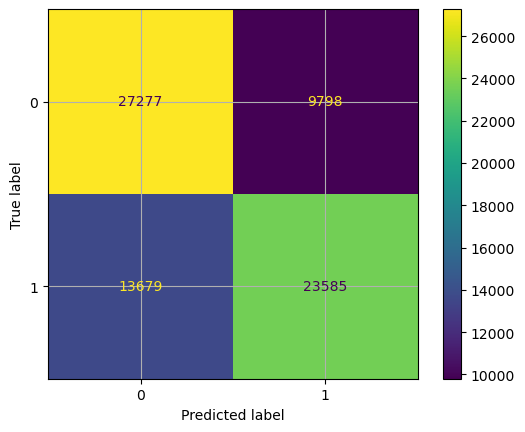

In [21]:
disp = ConfusionMatrixDisplay(confusion_matrix=matriz1)
plt.figure(figsize=(8, 6))
disp.plot(cmap='viridis')  
plt.grid(True)
plt.show()

### Support Vector Machine

In [23]:
SS = svm.LinearSVC()

In [24]:
# Para hacer la posterior representación de la curva de ROC, necesitamos obtener las probabilidades, y para ello usamos
# la función CalibratedClassifier
clf_svm = CalibratedClassifierCV(estimator=SS) 

In [25]:
# Ajustamos el modelo y realizamos la predicción
svm_model=clf_svm.fit(X_train_dtm, y_train)
pred_svm_model=svm_model.predict(X_test_dtm)

c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [26]:
# Descomposición de la precisión del segundo modelo
print(classification_report(y_test, pred_svm_model))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89     37075
           1       0.89      0.90      0.90     37264

    accuracy                           0.89     74339
   macro avg       0.89      0.89      0.89     74339
weighted avg       0.89      0.89      0.89     74339



In [27]:
# Matriz de decisión modelo SVM
matriz2=confusion_matrix(y_test, pred_svm_model)
encabezado=['SVM','IA','Human']
indice=['IA','Human']
print(tabulate(matriz2, headers=encabezado,showindex=indice, tablefmt='fancy_grid'))

accuracy_nb=svm_model.score(X_test_dtm, y_test)

╒═══════╤═══════╤═════════╕
│ SVM   │    IA │   Human │
╞═══════╪═══════╪═════════╡
│ IA    │ 32878 │    4197 │
├───────┼───────┼─────────┤
│ Human │  3665 │   33599 │
╘═══════╧═══════╧═════════╛


### X-Gboost

In [32]:
# Crear y ajustar el modelo XGBoost para clasificación
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train_dtm, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [33]:
# Hacer predicciones
pred_xgboost_model = xgboost_model.predict(X_test_dtm)

In [34]:
# Evaluación del modelo
accuracy_boost = accuracy_score(y_test, pred_xgboost_model)
print("Accuracy:", accuracy_boost)

Accuracy: 0.8981288421958864


In [35]:
# Metrics for Xgboost

print(classification_report(y_test, pred_xgboost_model))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90     37075
           1       0.88      0.92      0.90     37264

    accuracy                           0.90     74339
   macro avg       0.90      0.90      0.90     74339
weighted avg       0.90      0.90      0.90     74339



In [36]:

# Para hacer la comparativa con la curva de ROC, primero tenemos que obtener las probabilidades y después obtenemos los scores
y_score1 = nb_model.fit(X_train_dtm, y_train).predict_proba(X_test_dtm)[:,1]
y_score2 = svm_model.fit(X_train_dtm, y_train).predict_proba(X_test_dtm)[:,1]
y_score3 = xgboost_model.fit(X_train_dtm, y_train).predict_proba(X_test_dtm)[:,1]

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(y_test, y_score3)

roc1=roc_auc_score(y_test, y_score1)
roc2=roc_auc_score(y_test, y_score2)
roc3=roc_auc_score(y_test, y_score3)

c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\anano\anaconda3\envs\final_project\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


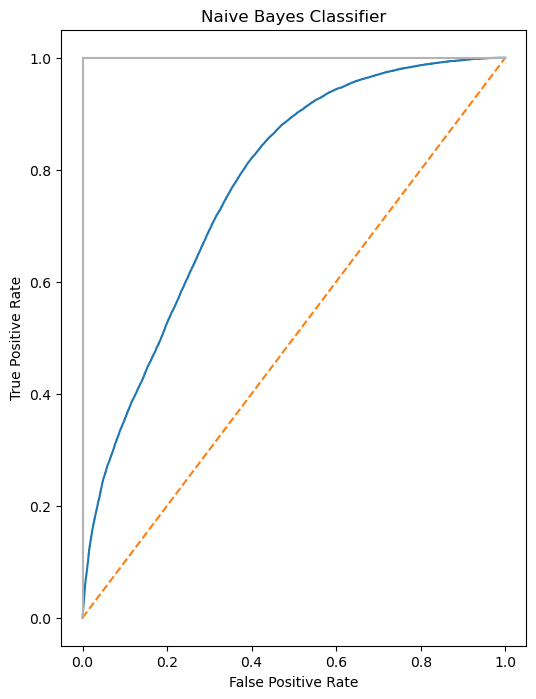

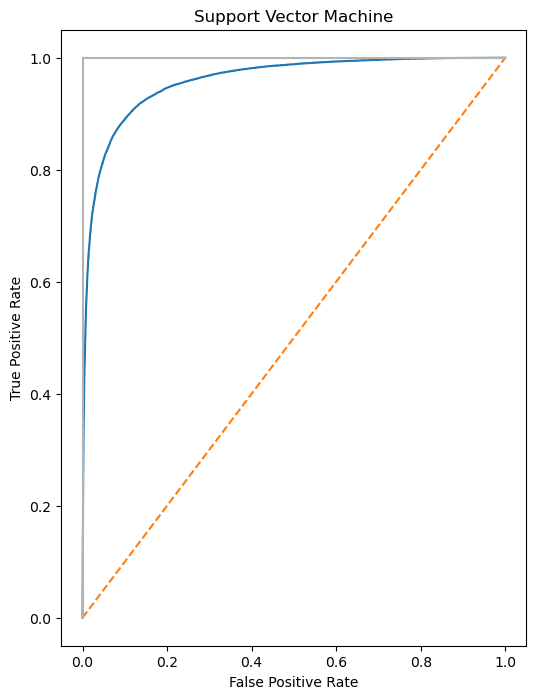

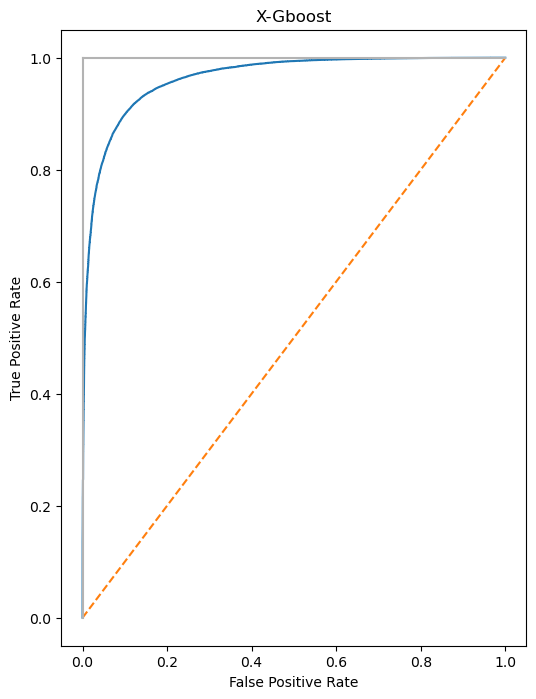

In [37]:
# Graficamos los valores de la curva ROC
plt.subplots(1, figsize=(6,8))
plt.title('Naive Bayes Classifier')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.subplots(1, figsize=(6,8))
plt.title('Support Vector Machine')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.subplots(1, figsize=(6,8))
plt.title('X-Gboost')
plt.plot(false_positive_rate3, true_positive_rate3)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [38]:

# Tabla resumen y comparativa entre la precisión y la curva ROC de los dos modelos


precision_mod1=precision_score(y_test, pred_nb_model, average='weighted')
precision_mod2=precision_score(y_test, pred_svm_model, average='weighted')
precision_mod3=precision_score(y_test, pred_xgboost_model, average='weighted')

recall_mod1=recall_score(y_test, pred_nb_model, average='weighted')
recall_mod2=recall_score(y_test, pred_svm_model, average='weighted')
recall_mod3=recall_score(y_test, pred_xgboost_model, average='weighted')

f1_mod1=f1_score(y_test, pred_nb_model, average='weighted')
f1_mod2=f1_score(y_test, pred_svm_model, average='weighted')
f1_mod3=f1_score(y_test, pred_xgboost_model, average='weighted')

summary1=[[precision_mod1,recall_mod1,f1_mod1,roc1],[precision_mod2,recall_mod2,f1_mod2,roc2],[precision_mod3,recall_mod3,f1_mod3,roc3]]
encabezado=['Ratios','Precision','Recall','F1 Score','ROC/AUC']
indice=['Naive Bayes','SVM', 'X-Gboost']
print(tabulate(summary1, headers=encabezado,showindex=indice, tablefmt='fancy_grid'))

╒═════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Ratios      │   Precision │   Recall │   F1 Score │   ROC/AUC │
╞═════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Naive Bayes │    0.686304 │ 0.68419  │   0.683369 │  0.775009 │
├─────────────┼─────────────┼──────────┼────────────┼───────────┤
│ SVM         │    0.894318 │ 0.894241 │   0.894234 │  0.959198 │
├─────────────┼─────────────┼──────────┼────────────┼───────────┤
│ X-Gboost    │    0.898651 │ 0.898129 │   0.89809  │  0.963714 │
╘═════════════╧═════════════╧══════════╧════════════╧═══════════╛
